# Tensorrec Python 모듈 추천 시스템 소매 고객 데이터를 이용한

by Taufik Azri

예제 데이터 : https://www.kaggle.com/darpan25bajaj/retail-case-study-data#prod_cat_info.csv

Tensorrec 모듈 정보 : https://github.com/jfkirk/tensorrec 

In [55]:
# Data Scientist가 사용하는 표준 패키지 가져오기
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn import preprocessing
from collections import Counter
import scipy.sparse as sparse

# os 는 시스템 디렉토리를 탐색하는 편리한 모듈
import os

# 텐서플로우를 백엔드로 사용하는 케라스를 import
import keras as ks

# Tensorrec 추천 패키지 import
import tensorrec
from tensorrec import TensorRec
from tensorrec.eval import *
from tensorrec.util import append_to_string_at_point

### 다른 표현 그래프(representation graph) 또한 대안으로 사용 가능. 모델을 조정하기 위해 자유롭게 시도해 보세요.
from tensorrec.representation_graphs import (AbstractKerasRepresentationGraph, 
#                                              ReLURepresentationGraph, 
                                             NormalizedLinearRepresentationGraph, 
#                                              LinearRepresentationGraph
                                            )

from tensorrec.loss_graphs import (WMRBLossGraph, 
#                                    BalancedWMRBLossGraph,
#                                    RMSELossGraph, 
#                                    RMSEDenseLossGraph, 
#                                    SeparationDenseLossGraph
                                  ) 

from tensorrec.eval import fit_and_eval, eval_random_ranks_on_dataset
from tensorrec.util import append_to_string_at_point

### tensorrec.representation_graphs.AbstractKerasRepresentationGraph를 상속하여 keras 표현 그래프를 구성.
### https://www.tensorflow.org/tensorboard/graphs
### 도움되는 article을 제작해준 James Kirk 에게 감사를 전한다. : 
### https://medium.com/hackernoon/deep-learning-for-recommendation-with-keras-and-tensorrec-2b8935c795d0

class DeepRepresentationGraph(AbstractKerasRepresentationGraph):
    # 이 method는 사용자/아이템 특징을 사용자/아이템에 연결하는 정렬된 리스트의 keras 레이어를 반환.
    # representation. TensorRec이 훈련이 시작되면 해당 레이어를 이용하여 훈련 진행.
    def create_layers(self, n_features, n_components):
        return [
            ks.layers.Dense(n_components * 16, activation='relu'), # rectified linear unit(ReLU)
            ks.layers.Dense(n_components * 8, activation='relu'), # 다른 활성화 함수 시도 가능 
            ks.layers.Dense(n_components * 2, activation='relu'), # 대부분의 활성화 함수 변경은 이미지 인식과 같은 ML 경우에서 도움.
            ks.layers.Dense(n_components, activation='tanh'),
        ]

Import the data manually from Kaggle and save it somewhere in the directory

The dowloaded data contains three separate csv files: Customer, prod_cat_info, and Transaction. We will refer the Transaction.csv as the master data, which we will append the relevant customer and product information from Customer.csv before we insert them into the engine.

In [56]:
# ### os.listdir을 사용하여 디렉토리 내의 파일 탐색
# os.listdir('../data')

# Data Preparation

In [57]:
#### 마스터 데이터(상호 작용)
#### 상호 작용(transaction) 마스터 데이터를 불러옴
masterdf = pd.read_csv('./data/Transactions.csv')
masterdf.head()

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type
0,80712190438,270351,28-02-2014,1,1,-5,-772,405.300,-4265.300,e-Shop
1,29258453508,270384,27-02-2014,5,3,-5,-1497,785.925,-8270.925,e-Shop
2,51750724947,273420,24-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop
3,93274880719,271509,24-02-2014,11,6,-3,-1363,429.345,-4518.345,e-Shop
4,51750724947,273420,23-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop


In [58]:
### 데이터 정리 및 표준화를 위해 데이터 열 명칭 변경
### 표준화는 병합의 용의성을 위해 열 명칭을 정렬
masterdf.columns = ['Transaction ID', 'Customer ID', 'Transaction Date', 'Prod Subcat Code',
       'Prod Cat Code', 'Qty', 'Rate', 'Tax', 'Total Amt', 'Store Type']

In [59]:
###  상점 코드 타입을 숫자형으로 변경하여 새 열에 저장
masterdf['Store Type Code'] = pd.factorize(masterdf['Store Type'])[0]
masterdf.head(5)

,Transaction ID,Customer ID,Transaction Date,Prod Subcat Code,Prod Cat Code,Qty,Rate,Tax,Total Amt,Store Type,Store Type Code
0,80712190438,270351,28-02-2014,1,1,-5,-772,405.300,-4265.300,e-Shop,0
1,29258453508,270384,27-02-2014,5,3,-5,-1497,785.925,-8270.925,e-Shop,0
2,51750724947,273420,24-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop,1
3,93274880719,271509,24-02-2014,11,6,-3,-1363,429.345,-4518.345,e-Shop,0
4,51750724947,273420,23-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop,1


In [60]:
masterdf

,Transaction ID,Customer ID,Transaction Date,Prod Subcat Code,Prod Cat Code,Qty,Rate,Tax,Total Amt,Store Type,Store Type Code
0,80712190438,270351,28-02-2014,1,1,-5,-772,405.300,-4265.300,e-Shop,0
1,29258453508,270384,27-02-2014,5,3,-5,-1497,785.925,-8270.925,e-Shop,0
2,51750724947,273420,24-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop,1
3,93274880719,271509,24-02-2014,11,6,-3,-1363,429.345,-4518.345,e-Shop,0
4,51750724947,273420,23-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop,1
...,...,...,...,...,...,...,...,...,...,...,...
23048,94340757522,274550,25-01-2011,12,5,1,1264,132.720,1396.720,e-Shop,0
23049,89780862956,270022,25-01-2011,4,1,1,677,71.085,748.085,e-Shop,0
23050,85115299378,271020,25-01-2011,2,6,4,1052,441.840,4649.840,MBR,2
23051,72870271171,270911,25-01-2011,11,5,3,1142,359.730,3785.730,TeleShop,1


In [61]:
### 분류가 유일한지 확인
masterdf[['Store Type', 'Store Type Code']].drop_duplicates()

,Store Type,Store Type Code
0,e-Shop,0
2,TeleShop,1
8,MBR,2
17,Flagship store,3


In [8]:
#### 소비자 데이터(소비자 특성)
custdf = pd.read_csv('./data/Customer.csv')
custdf.columns = ['Customer ID', 'DOB', 'Gender', 'City Code']
custdf.head(2)

,Customer ID,DOB,Gender,City Code
0,268408,02-01-1970,M,4.0
1,269696,07-01-1970,F,8.0


In [9]:
# City Code 속 null 개수
len(custdf[custdf['City Code'].isnull()])

2

In [10]:
## City Code 종류
custdf['City Code'].unique()

array([ 4.,  8.,  2.,  1.,  5.,  9.,  7., 10.,  6.,  3., nan])

In [11]:
## 상호 작용을 한 고객 수
len(custdf['Customer ID'].unique())

5647

In [12]:
## store type 종류
masterdf['Store Type'].unique()

array(['e-Shop', 'TeleShop', 'MBR', 'Flagship store'], dtype=object)

In [13]:
## 아이템 특징 데이터
skudf = pd.read_csv('./data/prod_cat_info.csv')
skudf.columns = ['Prod Cat Code', 'Prod Cat', 'Prod Sub Cat Code', 'Prod Subcat']
skudf.head()

,Prod Cat Code,Prod Cat,Prod Sub Cat Code,Prod Subcat
0,1,Clothing,4,Mens
1,1,Clothing,1,Women
2,1,Clothing,3,Kids
3,2,Footwear,1,Mens
4,2,Footwear,3,Women


Looks like there is not much info on the product, except the key-value for each category and subcategory.

# RFMV

In [14]:
## 거래 날짜를 pandas의 datetime index로 표준화 
masterdf['Date'] =  pd.DatetimeIndex(masterdf['Transaction Date'], dayfirst=True).date

In [15]:
### 첫 거래 날짜와 마지막 거래 날짜
print(masterdf['Date'].min()), print(masterdf['Date'].max())

2011-01-25
2014-02-28


(None, None)

In [16]:
### quantity와 based price에서 총 순 매출액(Net sales) 계산 (도시마다의 세금이 다를 수 있어 세금 제외)
masterdf['Net Sales'] = masterdf['Qty'] * masterdf['Rate']

In [17]:
### category, subcategory, store type을 이용하여 고유한 material 표시기를 생성
### 다른 sku는 다른 상점 유형에 판매된다고 가정
masterdf['Material'] = masterdf['Prod Cat Code'].astype(str) + '-' + masterdf['Prod Subcat Code'].astype(str) + '-' + masterdf['Store Type'].astype(str)

In [18]:
masterdf[['Prod Cat Code','Prod Subcat Code', 'Store Type', 'Material']].drop_duplicates(subset='Material').head(5)

,Prod Cat Code,Prod Subcat Code,Store Type,Material
0,1,1,e-Shop,1-1-e-Shop
1,3,5,e-Shop,3-5-e-Shop
2,5,6,TeleShop,5-6-TeleShop
3,6,11,e-Shop,6-11-e-Shop
5,3,8,TeleShop,3-8-TeleShop


In [19]:
### Material 종류 확인
len(masterdf['Material'].unique())

92

In [20]:
## '오늘(now)' 정보 획득, 이 경우 마지막 거래 날짜
## '오늘' 부터 가까울 수록 최신 데이터

import datetime as dt

now = dt.date(2014, 3, 1) # just take the max date from the index + 1
print(now)

2014-03-01


In [21]:
# RECENCY (최신성)
recency_df = masterdf.groupby('Customer ID').Date.max().reset_index()
recency_df.columns = ['Customer ID','Last Purchase']
recency_df['Recency'] = recency_df['Last Purchase'].apply(lambda x: (now - x).days)
recency_df = recency_df[['Customer ID', 'Recency']]
recency_df.head()

,Customer ID,Recency
0,266783,374
1,266784,452
2,266785,212
3,266788,382
4,266794,17


In [22]:
# FREQUENCY (빈도)
frequency_df = masterdf.groupby('Customer ID')['Date'].count().reset_index()
frequency_df.columns = ['Customer ID','Frequency']
frequency_df.head() 

,Customer ID,Frequency
0,266783,5
1,266784,3
2,266785,8
3,266788,4
4,266794,12


In [23]:
# MONETARY (금액)
monetary_df = masterdf.groupby('Customer ID')['Net Sales'].sum().reset_index()
monetary_df.columns = ['Customer ID','Monetary']
monetary_df.head()

,Customer ID,Monetary
0,266783,13386
1,266784,5153
2,266785,31920
3,266788,5514
4,266794,25569


In [24]:
# VARIETY (종류)
variety_df = masterdf.groupby('Customer ID')['Material'].nunique().reset_index()
variety_df.columns = ['Customer ID','Variety']
variety_df.head()

,Customer ID,Variety
0,266783,4
1,266784,3
2,266785,6
3,266788,4
4,266794,10


In [25]:
rfmv = recency_df.copy()

rfmv = rfmv.merge(frequency_df, on='Customer ID')
rfmv = rfmv.merge(monetary_df, on='Customer ID')
rfmv = rfmv.merge(variety_df, on='Customer ID')
rfmv.head(5)

,Customer ID,Recency,Frequency,Monetary,Variety
0,266783,374,5,13386,4
1,266784,452,3,5153,3
2,266785,212,8,31920,6
3,266788,382,4,5514,4
4,266794,17,12,25569,10


In [26]:
### R, F, M, V의 25%, 50%, 75%의 사분위수를 dictonary 형식으로 저장
rfmv_quantiles = rfmv.iloc[:, 1:].quantile(q = [0.25, 0.5, 0.75]).to_dict()
rfmv_quantiles

{'Recency': {0.25: 92.0, 0.5: 212.0, 0.75: 405.0},
 'Frequency': {0.25: 3.0, 0.5: 4.0, 0.75: 6.0},
 'Monetary': {0.25: 5041.75, 0.5: 8801.0, 0.75: 13749.0},
 'Variety': {0.25: 2.0, 0.5: 4.0, 0.75: 5.0}}

In [27]:
## 사분위수를 기준으로 하여 0-4의 점수를 반환하는 함수 생성
## 이러한 점수는 RFMB의 실제 값 대신 K-Mean 알고리즘으로 쉽게 해석 가능

### recency score: 오래될 수록 점수가 높음
def RecencyScore(i, col, df):
    if i <= df[col][0.25]:
        return 4
    elif i <= df[col][0.50]:
        return 3
    elif i <= df[col][0.75]: 
        return 2
    else:
        return 1
    
# F, M, V: Recency와 달리, 사분위수가 높을 수록 점수가 높다
def FMVScore(i, col, df):
    if i <= df[col][0.25]:
        return 1
    elif i <= df[col][0.50]:
        return 2
    elif i <= df[col][0.75]: 
        return 3    
    else:
        return 4

In [28]:
rfmv2 = rfmv.copy()

rfmv2['R_q'] = rfmv2['Recency'].apply(RecencyScore, args=('Recency', rfmv_quantiles ))
rfmv2['F_q'] = rfmv2['Frequency'].apply(FMVScore, args=('Frequency', rfmv_quantiles ))
rfmv2['M_q'] = rfmv2['Monetary'].apply(FMVScore, args=('Monetary', rfmv_quantiles ))
rfmv2['V_q'] = rfmv2['Variety'].apply(FMVScore, args=('Variety', rfmv_quantiles ))

rfmv2 = rfmv2[['Customer ID', 'R_q', 'F_q', 'M_q', 'V_q',]]

## 각 구성 요소의 총 점수 합계

rfmv2['Total_Score'] = rfmv2['R_q'] + rfmv2['F_q'] + rfmv2['M_q'] + rfmv2['V_q']

rfmv2 = rfmv2[['Customer ID', 'Total_Score']]

# 중요(IMPORTANT) : 인덱스를 고객 번호로 설정
rfmv2.index = rfmv2['Customer ID']
rfmv2 = rfmv2.drop('Customer ID', 1)

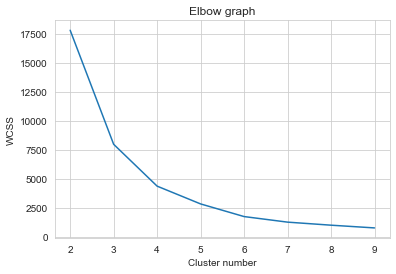

In [29]:
# 최적의 군집 수를 찾기 위해 elbow 방식을 사용

wcss = []
for i in range(2,10):
    kmeans = KMeans(n_clusters=i, 
                    init='k-means++')
    kmeans.fit(rfmv2)
    wcss.append(kmeans.inertia_)
    
# Elbow 방법의 그래프
plt.plot(range(2,10), wcss)
plt.title('Elbow graph')
plt.xlabel('Cluster number')
plt.ylabel('WCSS')
plt.show()

In [30]:
# 위 "elbow" 그래프의 최적의 수를 이용하여 KMean 군집 적용
kmeans = KMeans(n_clusters=4, 
                init='random', 
                random_state=None)

clusters = kmeans.fit_predict(rfmv2)

### 군진 결과를 원본 rfmv 데이터에 추가
rfmv['Clusters'] = clusters

In [31]:
rfmv.head(5)

,Customer ID,Recency,Frequency,Monetary,Variety,Clusters
0,266783,374,5,13386,4,1
1,266784,452,3,5153,3,2
2,266785,212,8,31920,6,0
3,266788,382,4,5514,4,3
4,266794,17,12,25569,10,0


In [32]:
### counter 기능은 각 고유값에 몇개가 있는지 확인
### 이 경우, 각 군집의 수 확인
Counter(clusters)

Counter({1: 1273, 2: 1436, 0: 1238, 3: 1559})

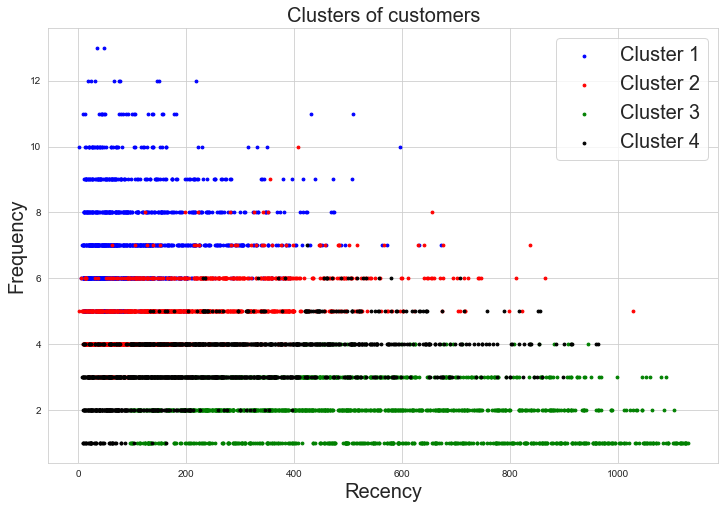

In [33]:
## optional: 군집의 모양을 보기위 각각의 RFMV로 두 구성요소 그래프 생성
## optional: RFMV의 다른 요소로 그래프 생성 가능

fig, ax = plt.subplots(figsize=(12,8))

var1 = 'Recency'
var2 = 'Frequency'
temp = rfmv.copy()

c1 = temp[temp.Clusters == 0]
c2 = temp[temp.Clusters == 1]
c3 = temp[temp.Clusters == 2]
c4 = temp[temp.Clusters == 3]

# 군집 시각화
plt.scatter(c1[var1], c1[var2], c = 'b', label = 'Cluster 1', s=8)
plt.scatter(c2[var1], c2[var2], c = 'r', label = 'Cluster 2', s=8)
plt.scatter(c3[var1], c3[var2], c = 'g', label = 'Cluster 3', s=8)
plt.scatter(c4[var1], c4[var2], c = 'k', label = 'Cluster 4', s=8)

plt.title('Clusters of customers', size=20)
plt.xlabel(var1, size=20)
plt.ylabel(var2, size=20)
plt.legend(fontsize=20)

# Recommendation Weight

In [34]:
### 비즈니스 경우에 rec 엔진은 명확한 고객에게만 추천을 하고 싶을 것이다.
### 여기선 최근 1년 365일을 기준으로 하여 실고객에게 추천
active_cust = rfmv[rfmv.Recency < 365]

In [35]:
### 군집화된 고객 특징을 마스터 데이터에 결합
cleaned_df = masterdf.merge(active_cust[['Customer ID','Clusters']], how='left', on='Customer ID')

## 군집을 기준으로 null 값이 존재하는 행 삭제
cleaned_df = cleaned_df[cleaned_df['Clusters'].notnull()]

## 소비자 데이터 추가
cleaned_df = cleaned_df.merge(custdf[['Customer ID', 'City Code']], how='left', 
                on='Customer ID')

### sku 특징(물품 카테고리) 를 마스터 데이터에 결합
cleaned_df = cleaned_df.merge(skudf[['Prod Cat', 'Prod Cat Code']], how='left', 
                on='Prod Cat Code')

In [36]:
### 데이터 상태 체크 transactions, customer, sku의 길이
len(cleaned_df), len(cleaned_df['Customer ID'].unique()), len(cleaned_df['Material'].unique())

(77908, 3899, 92)

In [37]:
# 필수 열 가져오기
# 불필요한 열 제거 및 필수 열 유지 
final_cleaned_df = cleaned_df

final_cleaned_df = final_cleaned_df[['Prod Cat','Material','Qty','Customer ID','Clusters',]]

# 그룹화 하여 각 고객의 전체 수량을 획득
# 고유한 고객 목록 유지, 중복 제거
cust_grouped = final_cleaned_df.groupby(['Customer ID',
                                         'Prod Cat',
                                         'Material',
                                        'Clusters']).sum().reset_index()


In [38]:
## Interaction Matrix 
## 판매 수량 측면에서 모든 Material에 대한 고객의 상호 작용 가져오기
interactions = cust_grouped.groupby(['Customer ID', 'Material'])['Qty'].sum().unstack().fillna(0)

# sklearn.preprocessing.MinMaxScaler을 이용하여 상호 작용 값 조정
minmaxscaler = preprocessing.MinMaxScaler()
interactions_scaled = minmaxscaler.fit_transform(interactions)
interactions_scaled = pd.DataFrame(interactions_scaled)

## 스케일 진행하며 index(고객), column(아이템) 정보 삭제 이러한 정보를 다시 설정
interactions_scaled.index = interactions.index
interactions_scaled.columns = interactions.columns

In [39]:
len(interactions.columns)

92

In [40]:
interactions

Material,1-1-Flagship store,1-1-MBR,1-1-TeleShop,1-1-e-Shop,1-3-Flagship store,1-3-MBR,1-3-TeleShop,1-3-e-Shop,1-4-Flagship store,1-4-MBR,...,6-11-TeleShop,6-11-e-Shop,6-12-Flagship store,6-12-MBR,6-12-TeleShop,6-12-e-Shop,6-2-Flagship store,6-2-MBR,6-2-TeleShop,6-2-e-Shop
Customer ID,,,,,,,,,,,,,,,,,,,,,
266785,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
266794,0.0,0.0,0.0,0.0,0.0,9.0,0.0,12.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
266799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
266804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
266805,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
275255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
275257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
### User Features Matrix 
## 고객이 구매하는 고유한 카테고리, 카테고리 별 수량으로 그룹화
cust_qty = cust_grouped.groupby(['Customer ID', 'Prod Cat'])['Qty'].sum().unstack().fillna(0)

# Scaled value of the categories
# sklearn.preprocessing.MinMaxScaler을 이용하여 categories 조정
minmaxscaler = preprocessing.MinMaxScaler()
cust_qty_scaled = minmaxscaler.fit_transform(cust_qty)
cust_qty_scaled = pd.DataFrame(cust_qty_scaled)
cust_qty_scaled.index = cust_qty.index
cust_qty_scaled.columns = cust_qty.columns

## 고객의 군집 특징을 포함하여, user feature에 추가하려는 추가 특징.
## 군집은 고객의 "특성" 역활. groupby를 이용하여 각 고객의 군집에 대한 원-핫 인코딩 진행
cust_clus = cust_grouped.groupby(['Customer ID', 'Clusters'])['Clusters'].nunique().unstack().fillna(0)
cust_clus

# 두개의 특징을 결합하여 User Features Matrix 생성 
customer_features = pd.merge(cust_qty_scaled, cust_clus, left_index=True, right_index=True, how='inner')
customer_features = customer_features.rename(columns={0: 'Cluster 0', 
                                                      1: 'Cluster 1', 
                                                      2: 'Cluster 2', 
                                                      3: 'Cluster 3', 
                                                      4: 'Cluster 4'})

## 추가적으로 성별 및 생년월일과 같은 소비자의 다른 정보를 포함 가능
## 하지만 지금은 이를 생략

In [42]:
### Item Features Matrix
## 아이템의 다른 카테고리를 특징으로 하여 item feature matrix 생성
item_category = pd.DataFrame(cust_grouped.groupby(['Material', 
                                              'Prod Cat'])['Qty'].sum().unstack().fillna(0).reset_index().set_index('Material'))

# 아이탬 카테고리 조정
minmaxscaler = preprocessing.MinMaxScaler()
item_category_scaled = minmaxscaler.fit_transform(item_category)
item_category_scaled = pd.DataFrame(item_category_scaled)
item_category_scaled.index = item_category.index
item_category_scaled.columns = item_category.columns

In [43]:
## TensorRec는 3가지 데이터 요구
## TensorRec의 경우 Dataframe 형식을 지원하지 않아 행렬 변환 필요

## Scipy 함수를 사용하여 COOMatrices 생성
## COOMatrices는 0으로 채워진 행렬
## 이는 프로세스 속도를 높이고 메모리를 절약
interaction_f = sparse.coo_matrix(interactions_scaled) 
user_f  = sparse.coo_matrix(customer_features) 
item_f  = sparse.coo_matrix(item_category_scaled) 

In [44]:
### Jesse Steinweg-Woods가 Recommendation metrics에 대하여 자세히 설명
### 다음 코드는 그의 방법을 참조
### https://jessesw.com/Rec-System/

def interaction_masking(interactions):
    '''
    This function will "mask" (a.k.a "hide") 20% of original interactions
    Masked items wil be considered not purchased

    '''
    mask_size = len(interactions.data)
    mask = np.random.choice(a=[False, True], size=mask_size, p=[.2, .8])
    not_mask = np.invert(mask)

    train_interactions = sparse.coo_matrix((interactions.data[mask],
                                        (interactions.row[mask],
                                         interactions.col[mask])),
                                       shape=interactions.shape)

    test_interactions = sparse.coo_matrix((interactions.data[not_mask],
                                       (interactions.row[not_mask],
                                        interactions.col[not_mask])),
                                      shape=interactions.shape)

    return train_interactions, test_interactions

In [45]:
mask_size = len(interaction_f.data)

## use numpy.random.choice to generate a random True/False array, where False denotes the "masked" interactions (hidden)
## https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.choice.html
np.random.choice(a=[False, True], 
                 size=mask_size, 
                 p=[.2, .8])

array([ True,  True,  True, ...,  True,  True,  True])

In [46]:
# 훈련 및 테스트를 위하여 interaction features에서 데이터 생성
train_interactions, test_interactions = interaction_masking(interaction_f)

# 사용자 특징, 아이템 정보 설정
user_features  = user_f
item_features = item_f

In [47]:
### %%time 을 호출하여 모델 실행 시간 확인

## 모델 파라미터
epochs = 200 # 최적의 학습 곡선을 얻기 위해 이 변수를 조절해 보세요
alpha = 0.01 
n_components =  100 ## 최적의 학습 곡선을 얻기 위해 이 변수를 조절해 보세요

verbose = False
learning_rate = 0.01
n_sampled_items = int(item_features.shape[0] * .1)
biased = True
 
k_val  = 100

## WMRB 근사 : 확장 가능한 배치 교육 접근 방식에서 순위를 매기는 학습.
## 상호 작용은 양수 값이 될 수 있지만 크기는 무시. 부정적인 상호 작용은 무시
## http://ceur-ws.org/Vol-1905/recsys2017_poster3.pdf
#  Options: BalancedWMRBLossGraph,RMSELossGraph, RMSEDenseLossGraph, SeparationDenseLossGraph

model = TensorRec(n_components = n_components,                 
                  user_repr_graph = DeepRepresentationGraph(),
                   item_repr_graph = NormalizedLinearRepresentationGraph(),
                   loss_graph = WMRBLossGraph(), 
                  biased=biased)

model.fit(train_interactions, 
          user_features, 
          item_features, 
          epochs=epochs, 
          verbose=False, 
          alpha=alpha, 
          n_sampled_items=n_sampled_items,
          learning_rate=learning_rate)

C:\Users\USER\anaconda3\envs\rec\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\USER\anaconda3\envs\rec\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [48]:
# 모든 사용자와 아이템에 대하여 예측 점수 생성
predictions = model.predict(user_features=user_features,
                            item_features=item_features)

# 모든 사용자와 아이템에 대하여 예측 랭크 (첫번째, 두번째, 세번재 ...) 생성
predicted_ranks = model.predict_rank(user_features=user_features,
                                     item_features=item_features)

In [62]:
# 기존의 masked 으론 precision 이 좋게 나올수 없음
# 하여 기존의 masked 방식에서 변경하여 user 기준의 분할로 변경
temp = interaction_f.A
temp[1000:] = 0
test_interactions = sparse.coo_matrix(temp)

temp = interaction_f.A
temp[:1000] = 0
train_interactions = sparse.coo_matrix(temp)

In [65]:
### TESTING

# Recall@k 사용 
# Recall@k: 평균 유저에 대하여, 테스트 항목 중 몇 퍼센트가 예상 순위에서 상위 K 에 존재하는가

# 즉, recall@k : 긍정적으로 평가 한 항목 (구매 한 항목) 중 몇 퍼센트가 예측의 상위 K 개 결과에 포함되었는 가

# in simpler words:
# Recall@k = (# 추천된 아이템 중 연관된 @k ) / (전체 관련 항목 수)
# a.k.a
# Recall@k = (# 추천 아이템 @k ) / (구매 한 총 품목 수)

### reference: 

## 추가적으로 400~500 개의 제품이 있는 경우 k ≈ 200-250으로 설정
## 하지만 지금은 92개의 제품인 관계로 K=80 이 적절
for K in [10,20,30,40,50,60,70,80,90]:
    r_at_k_test = recall_at_k(predicted_ranks, test_interactions, k=K)
    r_at_k_train = recall_at_k(predicted_ranks, train_interactions, k=K)

    p_at_k_test = precision_at_k(predicted_ranks, test_interactions, k=K)
    p_at_k_train = precision_at_k(predicted_ranks, train_interactions, k=K)

    f_at_k_test = f1_score_at_k(predicted_ranks, test_interactions, k=K)
    f_at_k_train = f1_score_at_k(predicted_ranks, train_interactions, k=K)

    print(K)
    print("Recall at @k: Train: {:.3f} Test: {:.3f} ".format(r_at_k_train.mean(), r_at_k_test.mean()))
    print("Precision at @k: Train: {:.3f} Test: {:.3f} ".format(p_at_k_train.mean(), p_at_k_test.mean()))
    print("F1 score at @k: Train: {:.3f} Test: {:.3f} ".format(f_at_k_train, f_at_k_test))

10
Recall at @k: Train: 0.138 Test: 0.138 
Precision at @k: Train: 0.710 Test: 0.709 
F1 score at @k: Train: 0.231 Test: 0.230 
20
Recall at @k: Train: 0.256 Test: 0.256 
Precision at @k: Train: 0.661 Test: 0.661 
F1 score at @k: Train: 0.370 Test: 0.369 
30
Recall at @k: Train: 0.394 Test: 0.395 
Precision at @k: Train: 0.678 Test: 0.678 
F1 score at @k: Train: 0.499 Test: 0.499 
40
Recall at @k: Train: 0.494 Test: 0.495 
Precision at @k: Train: 0.638 Test: 0.638 
F1 score at @k: Train: 0.557 Test: 0.558 
50
Recall at @k: Train: 0.615 Test: 0.615 
Precision at @k: Train: 0.634 Test: 0.634 
F1 score at @k: Train: 0.624 Test: 0.624 
60
Recall at @k: Train: 0.716 Test: 0.716 
Precision at @k: Train: 0.616 Test: 0.616 
F1 score at @k: Train: 0.662 Test: 0.662 
70
Recall at @k: Train: 0.797 Test: 0.798 
Precision at @k: Train: 0.587 Test: 0.587 
F1 score at @k: Train: 0.676 Test: 0.677 
80
Recall at @k: Train: 0.915 Test: 0.916 
Precision at @k: Train: 0.591 Test: 0.590 
F1 score at @k: Tr

In [53]:
# 읽을 수 있는 테이블(dataframe)로 순위 생성
ranks_df = pd.DataFrame(predicted_ranks)
ranks_df.columns = item_category_scaled.index
ranks_df.index = customer_features.index
ranks_df = ranks_df.T

In [54]:
ranks_df.head(5)

Customer ID,266785,266794,266799,266804,266805,266806,266809,266813,266814,266815,...,275245,275246,275247,275249,275250,275252,275255,275257,275261,275265
Material,,,,,,,,,,,,,,,,,,,,,
1-1-Flagship store,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
1-1-MBR,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
1-1-TeleShop,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
1-1-e-Shop,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
1-3-Flagship store,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
